# MMC Laboratorium 3

Autor: Jakub Ostrzołek

## Zadanie 1

### Metoda CTG - definicja generatora

Zgodnie ze wzorem:

$$Y=\frac{R_n-n/2}{\sqrt{n/12}}$$

In [28]:
import numpy as np
from typing import Any, Generator, NoReturn

def random_gauss(random_variables_count: int = 12) -> Generator[float, Any, NoReturn]:
    gen = np.random.default_rng()
    mean = random_variables_count/2
    std_dev = np.sqrt(random_variables_count/12)
    while True:
        x = gen.random(random_variables_count)
        yield (x.sum() - mean) / std_dev


### Generacja liczb

In [29]:
from itertools import islice

N = 5000
generator = random_gauss()
xs_elimination = [x for x in islice(generator, N)]
xs_elimination[:10]

[0.6158939740519971,
 0.14477797516263546,
 0.5008315670313532,
 0.5407045438952256,
 0.002158558224324203,
 -0.13789095517001915,
 0.4306225223094824,
 0.4764240072602117,
 -0.1614255496522441,
 0.41092815548418127]

### Wykres


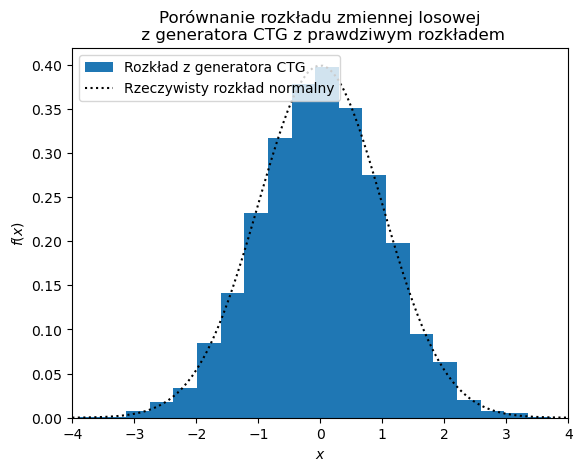

In [30]:
from matplotlib import pyplot as plt

N_exact = 100
xs_exact = np.linspace(-4, 4, N_exact)
ys_exact = 1./(np.sqrt(2.*np.pi))*np.exp(-np.power((xs_exact), 2.)/2)

plt.title("Porównanie rozkładu zmiennej losowej\n z generatora CTG z prawdziwym rozkładem")
plt.hist(xs_elimination, bins=20, density=True, label="Rozkład z generatora CTG")
plt.plot(xs_exact, ys_exact, "k:", label="Rzeczywisty rozkład normalny")
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.xlim((-4, 4))
plt.legend(loc="upper left")
plt.show()

Rozkład zmiennej losowej generowanej metodą CTG przypomina rozkład normalny. Niestety zmienna generowana w ten sposób nigdy nie osiągnie wartości spoza przedziału $[-\frac{n}{2}, \frac{n}{2}]$, co może być niedopuszczalne w niektórych zastosowaniach.

## Zadanie 3

### Metoda eliminacji - definicja generatora 

Zgodnie z algorytmem

1. Generujemy dwie niezależne zmienne losowe $U_1\sim U(x_{\min},\:x_{\max})$ i $U_2 \sim U(0,\:\max f(x))$.
   Zakładamy tu, że $f(x)$ przyjmuje wyłącznie wartości nieujemne.
2. Jeżeli $U_2 < f(U_1)$, algorytm zwraca $x = U_1$. W przeciwnym razie parę liczb $U_1$, pomijamy i wracamy
   do punktu 1.

In [31]:
import numpy as np
from typing import Callable

def random_from_distribution_elimination(
    distribution: Callable[[float], float],
    x_lim: tuple[float, float],
    y_max: float
) -> Generator[float, Any, NoReturn]:
    gen = np.random.default_rng()
    lim = np.array([x_lim, (0, y_max)])
    scale = lim[:, 1] - lim[:, 0]
    translation = lim[:, 0]
    while True:
        [x, y] = gen.random(2) * scale + translation
        if y <= distribution(x):
            yield x

#### Generacja liczb

In [32]:
def f(x: float) -> float:
    return 5/12 * (1 + np.power(x - 1, 4))

N = 100000

generator = random_from_distribution_elimination(f, (0, 2), 10/12)
xs_elimination = [x for x in islice(generator, N)]
xs_elimination[:10]

[0.16920536859509983,
 0.689967602148603,
 0.14682446957021944,
 0.44464548547302196,
 1.8317052392464381,
 0.9662599238949234,
 1.9594431145240365,
 0.16130435476710359,
 1.1591554582468722,
 0.2978372578021353]

### Metoda superpozycji - definicja generatora 

Zgodnie z algorytmem

1. Dostajemy $N$ par $(U_i, p_i)$, gdzie
   * $U_i$ - dowolna zmienna losowa, której rozkład możemy wygenerować,
   * $p_i$ - prawdopodobieństwo wykorzystania $i$-tej zmiennej losowej przy generacji wartości wyjściowej zmiennej
     losowej, $\sum^{N}_{i=1} p_i = 1$.
2. Generujemy zmienną losową $V \sim U(0, 1)$.
3. Wybieramy zmienną losową $U_k$, dla której $\sum^{k-1}_{i=0} p_i \le V < \sum^{k}_{i=0} p_i$
4. Generujemy zmienną losową zgodnie z rozkładem $U_k$.

In [33]:
def random_from_distribution_superposition(
    generators: list[Generator[float, Any, NoReturn]],
    probabilities: list[float],
) -> Generator[float, Any, NoReturn]:
    gen = np.random.default_rng()
    while True:
        generator = gen.choice(generators, p=probabilities)
        yield next(generator)

#### Generacja liczb

In [34]:
def g1() -> Generator[float, Any, NoReturn]:
    gen = np.random.default_rng()
    while True:
        yield gen.random() * 2

def g2() -> Generator[float, Any, NoReturn]:
    for x in g1():
        arg = x - 1
        power = np.power(arg, 0.2) if arg >= 0 else -np.power(-arg, 0.2)
        yield 1 + power


generator = random_from_distribution_superposition([g1(), g2()], [5/6, 1/6])
xs_superposition = [x for x in islice(generator, N)]
xs_superposition[:10]

[0.03462489925917489,
 1.5080786943335287,
 0.08345253872687042,
 0.13293987042580957,
 1.992602911483469,
 0.5058598794760654,
 1.99905342518766,
 0.8664938776669717,
 1.5832567363203403,
 1.3596775347424925]

### Wykres

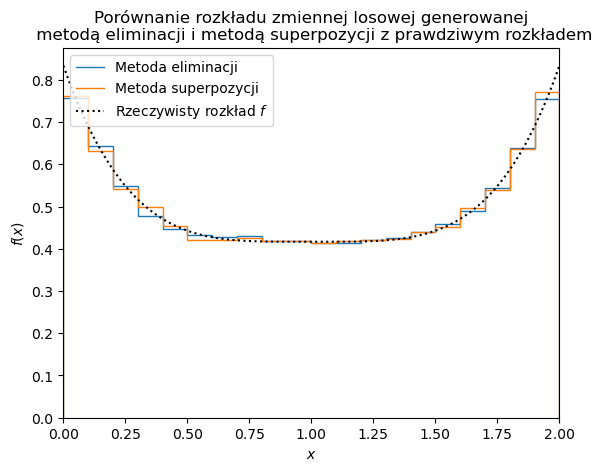

In [35]:
from matplotlib import pyplot as plt

N_exact = 100
xs_exact = np.linspace(0, 2, N_exact)
ys_exact = np.apply_along_axis(f, 0, xs_exact)

ys_elimination, bins_elimination = np.histogram(xs_elimination, bins=20, density=True)
ys_superposition, bins_superposition = np.histogram(xs_superposition, bins=20, density=True)

plt.title("Porównanie rozkładu zmiennej losowej generowanej\n metodą eliminacji i metodą superpozycji z prawdziwym rozkładem")
plt.stairs(ys_elimination, bins_elimination, label="Metoda eliminacji")
plt.stairs(ys_superposition, bins_superposition, label="Metoda superpozycji")
plt.plot(xs_exact, ys_exact, "k:", label="Rzeczywisty rozkład $f$")
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.xlim((0, 2))
plt.legend(loc="upper left")
plt.show()

Obie metody dają zadowalający efekt, bliski prawdziwemu rozkładowi zmiennej losowej. O dziwo, metoda superpozycji w tym przypadku działa wolniej niż metoda eliminacji, co może być spowodowane niższą złożonością obliczenia wartości $f$ (podnoszenie do 4-tej potęgi można zamienić na 2 mnożenia) niż wartości generatora $g_2$ (pierwiastek piątego stopnia).

Metoda ta może być stosowana jedynie do rozkładów o ograniczonej dziedzinie i wartościach, więc nie nadaje się np. do generacji rozkładu normalnego.